# 基于图的模型

前面已经学习完二分图，今天需要思考一下怎样在二分图上进行推荐。

参考资料：

- [1] [Pixie: A System for Recommending 3+ Billion Items to 200+ Million Users in Real-Time](https://arxiv.org/pdf/1711.07601.pdf)
- [2] 推荐系统实战.项亮

例如，将用户集合表示为U，将物品集合表示为V。则为用户u1推荐与u1没有直接边相连物品 vi。则需要衡量 vi 与 u1 之间的相关性。将相关性最大的 TOP K 物品推荐给用户 u1。

下面需要思考的问题就是，如何衡量用户 u1 与物品 vi 之间的相关性。查阅资料可以，主要取决于3个因素。

- 两个顶点之间的路径数（两个顶点之间的路径条数越多，越相关）
- 两个顶点之间路径的长度（连接两个顶点之间的路径越短，越相关）
- 两个顶点之间的路径经过的顶点（两个顶点之间经过的顶点其度越小，越相关）

定义好相关性之后（本质上相当与李航《统计学习方法》里的策略），其模型就是基于图的模型。则最后一个关键要素为：算法，即怎样有效的计算顶点之间的相关性。

这里使用基于随机游走的 PersonalRank 算法。

- 例如，假设给用户 u 推荐物品，则从 u 对应的节点 Vu 出发随机游走，当游走到任一节点时，按照概率 alpha 决定是两种选择：①继续游走，②停止这次游走并从 Vu 节点开始从新游走。
- 如果选择继续游走，则从当前节点指向的节点中按照均匀分布随机选择一个节点作为游走下次经过的节点。
- 这样，经过多次之后，每个物品被访问的概率会收敛到一个数。最终推荐给物品的权重大的。

![](./picture/1.png)

这里就有一个问题，只考虑用户是否喜欢某个物品，却无法考虑对某个物品的喜欢程度。

## 随机游走算法

- 使用 week1 的 ml-100k 数据
- 昨天使用了 snap 库的基本用法，感觉其实并不太方便。决定使用一下 networkx

In [1]:
# 导入常用库
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
% matplotlib inline

import networkx as nx
from networkx.algorithms import bipartite

### 1 使用一个简单的例子测试一下

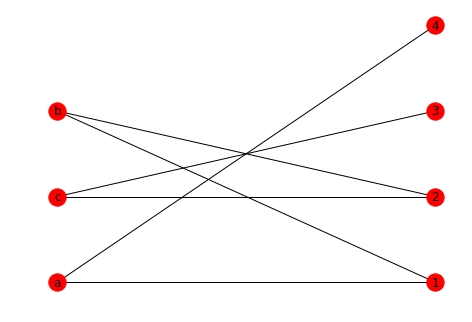

In [2]:
# 看看绘图情况
RB = nx.Graph()
RB.add_nodes_from([1, 2, 3, 4], bipartite=0)
RB.add_nodes_from(['a', 'b', 'c'], bipartite=1)
RB.add_edges_from([(1, 'a'), (1, 'b'), (2, 'b'), (2, 'c'), (3, 'c'), (4, 'a')])

X, Y = bipartite.sets(RB)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(RB, with_labels=True,pos=pos)
plt.show()

根据图的形式，进行随机游走算法计算

In [3]:
G = {1:{'a':1, 'b':1}, 2:{'b':1, 'c':1},
     3:{'c':1}, 4:{'a':1},
     'a':{1:1, 4:1}, 'b':{1:1, 2:1},
     'c':{2:1, 3:1}}

tmp = {k : 0 for k in G.keys()}
tmp

{1: 0, 2: 0, 3: 0, 4: 0, 'a': 0, 'b': 0, 'c': 0}

下面是参考《推荐系统实战》里面的方法

In [4]:
def PersonalRank(G, alpha, root):
    rank = dict()
    rank = {x:0 for x in G.keys()}
    rank[root] = 1
    for k in range(20):
        tmp = {x:0 for x in G.keys()}
        for i, ri in G.items():
            for j, wij in ri.items():
                if j not in tmp:
                    tmp[j] = 0
                tmp[j] += alpha * rank[i] / (1.0 * len(ri))
                if j == root:
                    tmp[j] += 1 - alpha
        rank = tmp
    return rank

In [5]:
rank = PersonalRank(G, 0.6, 1)
rank

{1: 1.012498801976991,
 2: 0.11386873080064037,
 3: 0.012496627824959085,
 4: 0.11112669900130956,
 'a': 0.37041803884204805,
 'b': 0.33790294751292244,
 'c': 0.04165159245672897}

In [6]:
def MyPersonalRank(G, alpha, root):
    rank = {x:0 for x in G.nodes}
    rank[root] = 1
    for k in range(20):
        tmp = {x:0 for x in G.nodes}
        for i in G.nodes:
            for j in G.neighbors(i):
                if j not in tmp:
                    tmp[j] = 0
                tmp[j] += alpha * rank[i] / len(list(G.neighbors(i)))
                if j == root:
                    tmp[j] += 1 - alpha
        rank = tmp
    return rank

In [7]:
rank = MyPersonalRank(RB, 0.6, 1)
rank

{1: 1.012498801976991,
 2: 0.11386873080064037,
 3: 0.012496627824959085,
 4: 0.11112669900130956,
 'a': 0.37041803884204805,
 'b': 0.33790294751292244,
 'c': 0.04165159245672897}

从上面的结果可以看出，两种计算的结果一致。对于 1 而言，由于只有 'c' 没有与其连接，故只能推荐 'c'。如果有多个物品，则推荐其分数最高的 TOP K个物品。

### 2 使用 ml-100k 数据进行实战

ml-100k 的数据在 week1 已经详细介绍过了，这里不再重复介绍。

#### 2.1 将 user 以及 item 节点，以及边信息保存到图中。

In [8]:
# 读入数据
path = './ml-100k/'
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'u.data', sep='\t', names=names)

In [9]:
ratings['u_user_id'] = ratings['user_id'].map(lambda x: 'u'+str(x))
ratings['i_item_id'] = ratings['item_id'].map(lambda x: 'i'+str(x))
ratings['edges'] = ratings.apply(lambda x: (x['u_user_id'], x['i_item_id']), axis = 1)

In [10]:
ratings.head()

,user_id,item_id,rating,timestamp,u_user_id,i_item_id,edges
0,196,242,3,881250949,u196,i242,"(u196, i242)"
1,186,302,3,891717742,u186,i302,"(u186, i302)"
2,22,377,1,878887116,u22,i377,"(u22, i377)"
3,244,51,2,880606923,u244,i51,"(u244, i51)"
4,166,346,1,886397596,u166,i346,"(u166, i346)"


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
user_id      100000 non-null int64
item_id      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
u_user_id    100000 non-null object
i_item_id    100000 non-null object
edges        100000 non-null object
dtypes: int64(4), object(3)
memory usage: 5.3+ MB


In [12]:
# 获得 user 节点，以及 item 节点
user_ids = ratings.u_user_id.unique().tolist()
item_ids = ratings.i_item_id.unique().tolist()
edges = ratings.edges.unique().tolist()
print 'user_ids : {}'.format(len(user_ids))
print 'item_ids : {}'.format(len(item_ids))

user_ids : 943
item_ids : 1682


In [13]:
B = nx.Graph()
B.add_nodes_from(user_ids, bipartite=0)
B.add_nodes_from(item_ids, bipartite=1)
B.add_edges_from(edges)
nx.is_connected(B)

True

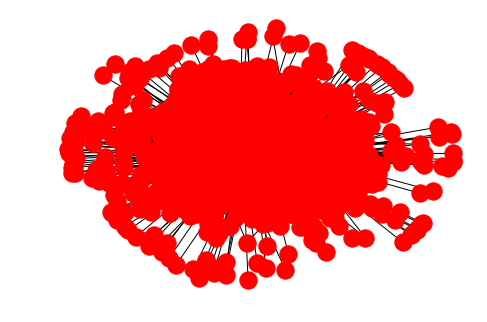

In [14]:
nx.draw(B)

上面绘制的图就乱了，参考 [Bipartite graph in NetworkX](https://stackoverflow.com/questions/27084004/bipartite-graph-in-networkx)完成绘图如下。

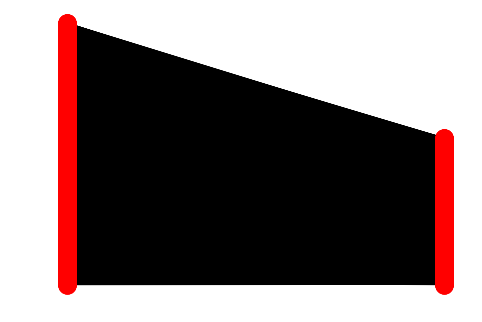

In [15]:
bottom_nodes, top_nodes = bipartite.sets(B)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(bottom_nodes) ) # put nodes from bottom_nodes at x=1
pos.update( (n, (2, i)) for i, n in enumerate(top_nodes) ) # put nodes from top_nodes at x=2
nx.draw(B, pos=pos)
plt.show()

数据太大，绘制出来的图的 edge 都重合在了一起。

Text(0.5,0,'rank')

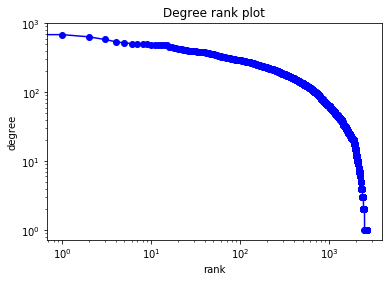

In [16]:
degree_sequence = sorted([d for n, d in B.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)

plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

从度的排名分布，可以看出，节点最大的度接近 10^3， 大部分节点的度在10以上

#### 2.2 训练以及预测数据

In [17]:
def train(G, alpha, root):
    rank = {x:0 for x in G.nodes}
    rank[root] = 1
    for k in range(20):
        tmp = {x:0 for x in G.nodes}
        for i in G.nodes:
            for j in G.neighbors(i):
                if j not in tmp:
                    tmp[j] = 0
                tmp[j] += alpha * rank[i] / len(list(G.neighbors(i)))
                if j == root:
                    tmp[j] += 1 - alpha
        rank = tmp
    return rank

In [18]:
def predict(data, rank, user, top_k):
    connect_item = [item_id for item_id in list(set(data[data['u_user_id'] == user]['i_item_id']))]
    recommend_item = [(key, rank[key]) for key in rank if key not in connect_item and 'u' not in key]
    top_k_item = sorted(recommend_item, key=lambda x: x[1], reverse=True)[:top_k]
    return top_k_item

In [19]:
rank = train(B, 0.6, 'u1')

In [20]:
len(rank)

2625

In [21]:
recom = predict(ratings, rank, 'u1', 10)

In [22]:
recom

[('i294', 0.15324470372122767),
 ('i286', 0.15246896722144535),
 ('i288', 0.15145396819736498),
 ('i300', 0.12786681732017557),
 ('i405', 0.12387859376964586),
 ('i423', 0.11455305433970654),
 ('i318', 0.11040922508396171),
 ('i276', 0.10648420155210174),
 ('i313', 0.10603439806671902),
 ('i357', 0.09957394871086585)]

In [23]:
# 对比一下 u1 真实评分过的电影
u1_love = ratings[ratings['u_user_id'] == 'u1'].sort_values(by=['rating'], ascending = False).iloc[:10]
u1_love

,user_id,item_id,rating,timestamp,u_user_id,i_item_id,edges
19996,1,170,5,876892856,u1,i170,"(u1, i170)"
7561,1,175,5,875072547,u1,i175,"(u1, i175)"
36844,1,119,5,876893098,u1,i119,"(u1, i119)"
38193,1,181,5,874965739,u1,i181,"(u1, i181)"
40519,1,109,5,874965739,u1,i109,"(u1, i109)"
9255,1,44,5,878543541,u1,i44,"(u1, i44)"
9170,1,14,5,874965706,u1,i14,"(u1, i14)"
8976,1,12,5,878542960,u1,i12,"(u1, i12)"
40783,1,223,5,876892918,u1,i223,"(u1, i223)"
8834,1,108,5,875240920,u1,i108,"(u1, i108)"


In [24]:
recom_list = [int(key[0][1:]) for key in recom]
names = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']
movie = pd.read_csv(path+'u.item', sep='|', names=names)
df_recom = movie[(movie.movie_id.isin(recom_list))]

In [25]:
print '推荐的电影'
df_recom

推荐的电影


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
275,276,Leaving Las Vegas (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Leaving%20Las...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
285,286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
287,288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
293,294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
312,313,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
317,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
356,357,One Flew Over the Cuckoo's Nest (1975),01-Jan-1975,NaN,http://us.imdb.com/M/title-exact?One%20Flew%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,405,Mission: Impossible (1996),22-May-1996,NaN,http://us.imdb.com/M/title-exact?Mission:%20Im...,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
422,423,E.T. the Extra-Terrestrial (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?E%2ET%2E%20th...,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [26]:
print '用户评分前十的电影'
df_love = movie[(movie.movie_id.isin(u1_love.item_id.tolist()))]
df_love

用户评分前十的电影


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
11,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13,14,"Postino, Il (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Postino,%20Il...",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
43,44,Dolores Claiborne (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Dolores%20Cla...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
107,108,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,109,Mystery Science Theater 3000: The Movie (1996),19-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Mystery%20Sci...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
118,119,Maya Lin: A Strong Clear Vision (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Maya%20Lin:%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,170,Cinema Paradiso (1988),01-Jan-1988,NaN,http://us.imdb.com/M/title-exact?Nuovo%20cinem...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
174,175,Brazil (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Brazil%20(1985),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
222,223,Sling Blade (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Sling%20Blade...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


- 通过对比电影的属性特征，发现这两种类型的电影确实有一定的相似性。例如，可以看出来两种类型的电影中的 'Romance' 类型的电影较多。
- 但是这样比较的方式，太人为主管了，下面将通过更加科学的评价方式来实现。
- 评价指标：精确率 precision, 召回率 recall

## 3 使用验证集训练，测试集进行测试

In [27]:
# 读入数据
names = ['user_id', 'item_id', 'rating', 'timestamp']
df_train = pd.read_csv(path+'u1.base', sep='\t', names=names)
df_test = pd.read_csv(path+'u1.test', sep='\t', names=names)
print len(df_train)
print len(df_test)

80000
20000


由于是无权重图，为了简化模型，认为 user 评论了 movie，则代表其看过该 movie，则我们应该像其推荐该 movie

In [28]:
def preprocess(data):

    data['u_user_id'] = data['user_id'].map(lambda x: 'u'+str(x))
    data['i_item_id'] = data['item_id'].map(lambda x: 'i'+str(x))
    data['edges'] = data.apply(lambda x: (x['u_user_id'], x['i_item_id']), axis = 1)

    # 获得 user 节点，以及 item 节点
    user_ids = data.u_user_id.unique().tolist()
    item_ids = data.i_item_id.unique().tolist()
    edges = data.edges.unique().tolist()
    print 'user_ids : {}'.format(len(user_ids))
    print 'item_ids : {}'.format(len(item_ids))
    
    B = nx.Graph()
    B.add_nodes_from(user_ids, bipartite=0)
    B.add_nodes_from(item_ids, bipartite=1)
    B.add_edges_from(edges)
    print nx.is_connected(B)
    return B

In [29]:
B_train = preprocess(df_train)
B_test = preprocess(df_test)

user_ids : 943
item_ids : 1650
True
user_ids : 459
item_ids : 1410
True


In [30]:
df_test.head()

,user_id,item_id,rating,timestamp,u_user_id,i_item_id,edges
0,1,6,5,887431973,u1,i6,"(u1, i6)"
1,1,10,3,875693118,u1,i10,"(u1, i10)"
2,1,12,5,878542960,u1,i12,"(u1, i12)"
3,1,14,5,874965706,u1,i14,"(u1, i14)"
4,1,17,3,875073198,u1,i17,"(u1, i17)"


In [31]:
def train(G, alpha, root):
    rank = {x:0 for x in G.nodes}
    rank[root] = 1
    for k in range(20):
        tmp = {x:0 for x in G.nodes}
        for i in G.nodes:
            for j in G.neighbors(i):
                if j not in tmp:
                    tmp[j] = 0
                tmp[j] += alpha * rank[i] / len(list(G.neighbors(i)))
                if j == root:
                    tmp[j] += 1 - alpha
        rank = tmp
    return rank

def predict(data, rank, user, top_k):
    connect_item = [item_id for item_id in list(set(data[data['u_user_id'] == user]['i_item_id']))]
    recommend_item = [(key, rank[key]) for key in rank if key not in connect_item and 'u' not in key]
    top_k_item = sorted(recommend_item, key=lambda x: x[1], reverse=True)[:top_k]
    return top_k_item

In [32]:
def precision(test, user, top_k_item):
    r_all = len(top_k_item)
    recom_list = [int(key[0][1:]) for key in top_k_item]
    data = test[test.u_user_id==user]
    r = len(data[(data.item_id.isin(recom_list))].item_id.unique())
    p = r*1.0/r_all
    return p

In [33]:
def recall(test, user ,top_k_item):
    tu = test[test.u_user_id == user]['item_id'].nunique()
    recom_list = [int(key[0][1:]) for key in top_k_item]
    data = test[test.u_user_id==user]
    r = len(data[(data.item_id.isin(recom_list))].item_id.unique())
    rec = r*1.0/tu
    return rec

In [34]:
# 以 user_id = 1 为例
# B_train 需要将 df_test 与 u1 相连的 item 节点加入进去。加上边连接上item除了 u1 的边
item_ids = df_test[df_test.u_user_id == 'u1'].i_item_id.unique().tolist()
B_train.add_nodes_from(item_ids, bipartite=1)

edges = df_test[(df_test.i_item_id.isin(item_ids) & (df_test.u_user_id != 'u1'))].edges.unique().tolist()
B_train.add_edges_from(edges)
print nx.is_connected(B_train)

rank_1 = train(B_train, 0.6, 'u1')

top_k = 1600
top_k_item_1 = predict(df_train, rank_1, 'u1', top_k)
p = precision(df_test, 'u1', top_k_item_1)
print "精确率 ：{}".format(p)
r = recall(df_test, 'u1' ,top_k_item_1)
print "召回率 ：{}".format(r)

True
精确率 ：0.0904290429043
召回率 ：1.0


上面可以看出，推荐 1600 个物品时，召回率为1，说明 user1 的物品全部推荐到了，但是精确率为0.09说明，推荐的大部分都不对。这是符合我们认知的。下面，减小推荐的数量

In [35]:
top_k = 100
top_k_item_1 = predict(df_train, rank_1, 'u1', top_k)
p = precision(df_test, 'u1', top_k_item_1)
print "精确率 ：{}".format(p)
r = recall(df_test, 'u1' ,top_k_item_1)
print "召回率 ：{}".format(r)

精确率 ：0.55
召回率 ：0.401459854015


可以看出来召回率下降的同时，精确率有了提升。这就说明，通过设置推荐不同的推荐物品的数量，是可以调控不同的精确率和召回率。这对不同的场景需要不同的设置

## 继续思考

有了 rank 的统计之后，其实还可以做很多的事情。例如：

- 给定一个用户，推荐 TOP K 个物品
- 给定一个用户，推荐与其最相似的TOP K 个用户，这样根据这 TOP K个用户，大概反应出给定用户的风格，口味。
- 给定一个物品，推荐最可能购买的 TOP K个用户
- 给定一个物品，推荐与其最相似的 TOP K个物品。这样，如果某个用户购买了该给定物品，则有可能也购买与其相似的 TOP K个物品。

### 上面实现了给定一个用户，推荐TOP K个物品。下面来实现其他3种情况

#### Given a user, recommend top K users

In [37]:
def predict_2(data, rank, user, top_k):
    recommend_item = [(key, rank[key]) for key in rank if 'u' in key]
    top_k_user = sorted(recommend_item, key=lambda x: x[1], reverse=True)[:top_k]
    return top_k_user

In [40]:
# 对 u1 进行测试
recom_user = predict_2(df_train, rank_1, 'u1', 11)
recom_user

[('u1', 54.52193049168424),
 ('u405', 0.26884352363731323),
 ('u655', 0.2558907756382409),
 ('u450', 0.17882656484161433),
 ('u682', 0.17851696237057937),
 ('u537', 0.1647901610090184),
 ('u234', 0.15852837054454608),
 ('u846', 0.15726027492852337),
 ('u551', 0.15276571091991728),
 ('u642', 0.15194227039391278),
 ('u13', 0.14533022806072848)]

#### Given an item, recommend top K items

In [42]:
def predict_3(data, rank, item, top_k):
    recommend_item = [(key, rank[key]) for key in rank if 'i' in key]
    top_k_item = sorted(recommend_item, key=lambda x: x[1], reverse=True)[:top_k]
    return top_k_item

In [43]:
rank_item_1 = train(B_train, 0.6, 'i1')
recom_item = predict_3(df_train, rank_item_1, 'i1', 11)
recom_item

[('i1', 154.19335802001666),
 ('i100', 0.7000761310964541),
 ('i50', 0.6832728073437634),
 ('i121', 0.6394814744473492),
 ('i258', 0.6039699593954139),
 ('i117', 0.5912159576904542),
 ('i181', 0.582652001036578),
 ('i222', 0.536724381597521),
 ('i294', 0.5282046381210629),
 ('i151', 0.4876129582214505),
 ('i237', 0.4804695473606781)]

## 4 测试全部的用户

放在 day_3 完成